<a href="https://colab.research.google.com/github/paveethranswam/Speech-style-transfer-and-ASR/blob/main/Inference_on_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5b1293d3-6437-0df9-3377-51c9126fe6b5)


In [5]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [6]:
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os

import IPython
import requests
import torchaudio
from IPython.display import Audio, display

In [8]:
!unzip "/content/drive/My Drive/DLS_Project/Dataset/DR-VCTK/DR-VCTK.zip" -d "./DR-VCTK"

Streaming output truncated to the last 5000 lines.
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_004.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_005.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_006.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_007.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_009.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_010.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_011.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_012.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_013.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_014.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_01

In [9]:
DR_VCTK_DATASET_PATH = "./DR-VCTK/"

In [10]:
os.makedirs(DR_VCTK_DATASET_PATH, exist_ok=True)
print(DR_VCTK_DATASET_PATH)

./DR-VCTK/


In [11]:
# Getting precomputed transcript mapping
import pickle
from google.colab import files

with open('./final_w2v_transcript_dictionary2.pkl', 'rb') as f:
    speaker_utterance_final = pickle.load(f)

In [12]:
drvctk_train_dataset = torchaudio.datasets.DR_VCTK(DR_VCTK_DATASET_PATH, subset='train',download=False)

In [13]:
drvctk_test_dataset = torchaudio.datasets.DR_VCTK(DR_VCTK_DATASET_PATH, subset='test',download=False)

In [14]:
print(len(drvctk_train_dataset))
print(len(drvctk_test_dataset))

11572
824


In [15]:
# Testing one sample in the DR-VCTK dataset
for sample_id, sample in enumerate(drvctk_train_dataset):
  clean_waveform, clean_waveform_sample_rate, noisy_waveform, noisy_waveform_sample_rate, speaker_id, utterance_id, source, channel_id = sample

  print("Clean Waveform, Sample Rate: {}".format(clean_waveform_sample_rate))
  

  print("Noisy Waveform, Sample Rate: {}".format(noisy_waveform_sample_rate))


  sample_transcript = speaker_utterance_final[speaker_id][utterance_id]

  print('Sample ID: {}, Speaker ID: {}, Utterance ID: {}, Source: {}, Channel ID: {}'.format(sample_id,speaker_id, utterance_id, source, channel_id))
  print("Sample Transcript: {}".format(sample_transcript))
  break

Clean Waveform, Sample Rate: 16000
Noisy Waveform, Sample Rate: 16000
Sample ID: 0, Speaker ID: p226, Utterance ID: 001, Source: DR-VCTK_Office1_ClosedWindow, Channel ID: 1
Sample Transcript: PLEASE|CALL|STELLA|


In [16]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [17]:
labels = list(bundle.get_labels())

In [18]:
# Encode trasncripts

def label_to_index(word):
    res = []
    for i in range(len(word)):

      res.append(labels.index(word[i]))

    # Return the position of the word in labels
    return torch.tensor(res)

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    res = []
    for i in range(index.size()[0]):
      ch = labels[index[i]]
      res.append(ch)
    return "".join(res)

In [19]:
index_to_label(label_to_index("|PLE-ASE|CAL'L|STELLA|"))

"|PLE-ASE|CAL'L|STELLA|"

In [20]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    clean_tensors,noisy_tensors,targets = [], [], []

    # Gather in lists, and encode labels as indices
    for clean_waveform, _, noisy_waveform, _, speaker_id, utterance_id, _, _ in batch:

        sample_transcript = speaker_utterance_final[speaker_id][utterance_id]

        clean_tensors += [clean_waveform]
        noisy_tensors += [noisy_waveform]
        targets += [sample_transcript]

    # Group the list of tensors into a batched tensor
    # print(clean_tensors[0].size())
    clean_tensors = pad_sequence(clean_tensors)
    # print(clean_tensors[0].size())
    noisy_tensors = pad_sequence(noisy_tensors)
    # print(targets[0].size())
    # targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)
    # print(targets[0].size())
    # print(index_to_label(targets[0]))
    # targets = torch.stack(targets)

    return clean_tensors,noisy_tensors, targets


batch_size = 5

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    drvctk_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    drvctk_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [21]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [22]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [23]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())

In [24]:
!pip install jiwer
from jiwer import wer
from jiwer import cer
import jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 36.6 MB/s 
     |████████████████████████████████| 2.2 MB 60.1 MB/s 


In [25]:
# Get some exmaple predictions

clean_data,noisy_data,target = next(iter(test_loader))

clean_data = clean_data.to(device)
noisy_data = noisy_data.to(device)

with torch.inference_mode():
   
  clean_data = clean_data.squeeze(1)
  noisy_data = noisy_data.squeeze(1)

  emission_clean, _ = model(clean_data)
  emission_noisy, _ = model(noisy_data)

  for i in range(emission_clean.size()[0]): 

    transcript_clean = decoder(emission_clean[i])
    transcript_noisy = decoder(emission_noisy[i])

    print("Sample: {}".format(i))
    print("Predicted clean output: {}".format(transcript_clean))
    print("Predicted noisy output: {}".format(transcript_noisy))
    print("Real label transcript: {}".format(target[i]))
    print()




Sample: 0
Predicted clean output: PLEASE|CALL|STELLA|
Predicted noisy output: PLEASE|CALLED|STELLA|
Real label transcript: PLEASE|CALL|STELLA|

Sample: 1
Predicted clean output: ASK|HER|TO|BRING|THESE|THINGS|WITH|HER|FROM|THE|STORE|
Predicted noisy output: ASK|HER|TO|BRING|THESE|THINGS|WITH|HER|FROM|THE|STORE|
Real label transcript: ASK|HER|TO|BRING|THESE|THINGS|WITH|HER|FROM|THE|STORE|

Sample: 2
Predicted clean output: SIX|SPOONS|OF|FRESH|SNOW|BEESE|FIVE|THICK|SLABS|OF|BLUE|CHEESE|AND|MAYBE|A|SNACK|WERE|HER|BROTHER|BOB|
Predicted noisy output: SIX|SPOONS|OF|FRESH|SNOW|BEESE|FIVE|THICK|SLAPS|OF|BLUE|CHEESE|AND|MANY|A|SNACK|WILL|HAVE|BROUGHT|A|BOB|
Real label transcript: SIX|SPOONS|OF|FRESH|SNOW|PEAS|FIVE|THICK|SLABS|OF|BLUE|CHEESE|AND|MAYBE|A|SNACK|FOR|HER|BROTHER|BOB|

Sample: 3
Predicted clean output: SHE|CAN|SCOOP|THESE|THINGS|INTO|THREE|RED|BAGS|AND|WE|WILL|GO|MEET|HER|WEDNESDAY|AT|THE|TRAINSTATION|
Predicted noisy output: SHE|CAN|SCOOP|THESE|THINGS|INTO|THREE|RED|BAGS|AND|WE|WILL

In [26]:
clean_data,noisy_data,target = next(iter(test_loader))

In [27]:
# Extract Acoustic features from model for toy sample
with torch.inference_mode():
    features, _ = model.extract_features(clean_data[0].to(device))

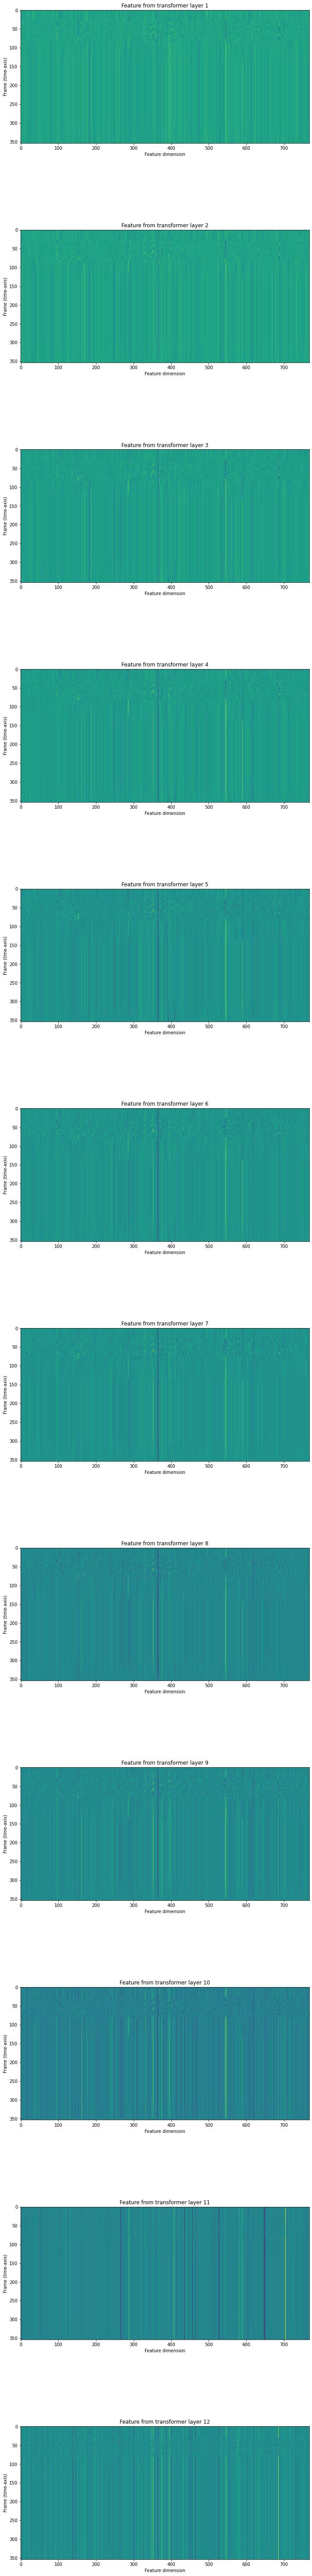

In [28]:
fig, ax = plt.subplots(len(features), 1, figsize=(10, 7 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

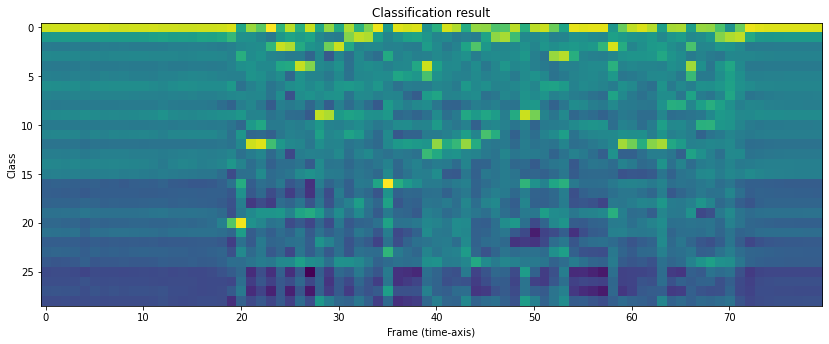

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [29]:
# Extract classification result for toy sample
with torch.inference_mode():
    emission, _ = model(clean_data[0].to(device))

sample_probs = emission[0].cpu().T

fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.imshow(sample_probs[:,10:90])
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [30]:
transcript_pred = decoder(emission[0])

print("Example Sample")
print("Predicted clean output: {}".format(transcript_pred))
print("Real label transcript: {}".format(target[0]))

Example Sample
Predicted clean output: PLEASE|CALL|STELLA|
Real label transcript: PLEASE|CALL|STELLA|


In [31]:
clean_metrics = {"wer": 0, "cer": 0}
noisy_metrics = {"wer": 0, "cer": 0}

for clean_data,noisy_data,target in test_loader:

  clean_data = clean_data.to(device)
  noisy_data = noisy_data.to(device)
 
  with torch.inference_mode():
   
    clean_data = clean_data.squeeze(1)
    noisy_data = noisy_data.squeeze(1)

    emission_clean, _ = model(clean_data)
    emission_noisy, _ = model(noisy_data)

    for i in range(emission_clean.size()[0]): 

      transcript_clean = decoder(emission_clean[i])
      transcript_noisy = decoder(emission_noisy[i])

      clean_metrics["wer"] += wer(target[i], transcript_clean) 
      noisy_metrics["wer"] += wer(target[i], transcript_noisy)

      clean_metrics["cer"] += cer(target[i], transcript_clean)
      noisy_metrics["cer"] += cer(target[i], transcript_noisy)

clean_metrics["wer"] = clean_metrics["wer"] / len(drvctk_test_dataset)
clean_metrics["cer"] = clean_metrics["cer"] / len(drvctk_test_dataset)

noisy_metrics["wer"] = noisy_metrics["wer"] / len(drvctk_test_dataset)
noisy_metrics["cer"] = noisy_metrics["cer"] / len(drvctk_test_dataset)

print("Pretrained Wave2vec DR-VCTK test clean data WER: {}".format(clean_metrics["wer"]))
print("Pretrained Wave2vec DR-VCTK test noisy data WER: {}".format(noisy_metrics["wer"]))

print("Pretrained Wave2vec DR-VCTK test clean data CER: {}".format(clean_metrics["cer"]))
print("Pretrained Wave2vec DR-VCTK test noisy data CER: {}".format(noisy_metrics["cer"]))

Pretrained Wave2vec DR-VCTK test clean data WER: 0.38228155339805825
Pretrained Wave2vec DR-VCTK test noisy data WER: 0.8240291262135923
Pretrained Wave2vec DR-VCTK test clean data CER: 0.0325733077621744
Pretrained Wave2vec DR-VCTK test noisy data CER: 0.17812873190676126


In [32]:
clean_metrics = {"wer": 0, "cer": 0}
noisy_metrics = {"wer": 0, "cer": 0}

for clean_data,noisy_data,target in train_loader:

  clean_data = clean_data.to(device)
  noisy_data = noisy_data.to(device)
 
  with torch.inference_mode():
   
    clean_data = clean_data.squeeze(1)
    noisy_data = noisy_data.squeeze(1)

    emission_clean, _ = model(clean_data)
    emission_noisy, _ = model(noisy_data)

    for i in range(emission_clean.size()[0]): 

      transcript_clean = decoder(emission_clean[i])
      transcript_noisy = decoder(emission_noisy[i])

      clean_metrics["wer"] += wer(target[i], transcript_clean) 
      noisy_metrics["wer"] += wer(target[i], transcript_noisy)

      clean_metrics["cer"] += cer(target[i], transcript_clean)
      noisy_metrics["cer"] += cer(target[i], transcript_noisy)

clean_metrics["wer"] = clean_metrics["wer"] / len(drvctk_train_dataset)
clean_metrics["cer"] = clean_metrics["cer"] / len(drvctk_train_dataset)

noisy_metrics["wer"] = noisy_metrics["wer"] / len(drvctk_train_dataset)
noisy_metrics["cer"] = noisy_metrics["cer"] / len(drvctk_train_dataset)

print("Pretrained Wave2vec DR-VCTK train clean data WER: {}".format(clean_metrics["wer"]))
print("Pretrained Wave2vec DR-VCTK train noisy data WER: {}".format(noisy_metrics["wer"]))

print("Pretrained Wave2vec DR-VCTK train clean data CER: {}".format(clean_metrics["cer"]))
print("Pretrained Wave2vec DR-VCTK train noisy data CER: {}".format(noisy_metrics["cer"]))

Pretrained Wave2vec DR-VCTK train clean data WER: 0.402955409609402
Pretrained Wave2vec DR-VCTK train noisy data WER: 0.7636536467334947
Pretrained Wave2vec DR-VCTK train clean data CER: 0.034911269477955115
Pretrained Wave2vec DR-VCTK train noisy data CER: 0.1423565968489096


In [33]:
# Running inference on GAN inputs

In [34]:
E_GAN_INPUT_PATH = "./English_Input/"
I_GAN_INPUT_PATH = "./Indian_Input/"

In [35]:
os.makedirs(E_GAN_INPUT_PATH, exist_ok=True)
os.makedirs(I_GAN_INPUT_PATH, exist_ok=True)
print(E_GAN_INPUT_PATH)
print(I_GAN_INPUT_PATH)

./English_Input/
./Indian_Input/


In [36]:
!unzip "/content/drive/My Drive/DLS_Project/Dataset/English_Speakers-input.zip" -d "./English_Input/"

Archive:  /content/drive/My Drive/DLS_Project/Dataset/English_Speakers-input.zip
  inflating: ./English_Input/English_Speakers/english_p225_094.wav  
  inflating: ./English_Input/English_Speakers/english_p225_118.wav  
  inflating: ./English_Input/English_Speakers/english_p225_124.wav  
  inflating: ./English_Input/English_Speakers/english_p225_143.wav  
  inflating: ./English_Input/English_Speakers/english_p225_111.wav  
  inflating: ./English_Input/English_Speakers/english_p225_127.wav  
  inflating: ./English_Input/English_Speakers/english_p225_116.wav  
  inflating: ./English_Input/English_Speakers/english_p225_121.wav  
  inflating: ./English_Input/English_Speakers/english_p225_108.wav  
  inflating: ./English_Input/English_Speakers/english_p225_113.wav  
  inflating: ./English_Input/English_Speakers/english_p225_136.wav  
  inflating: ./English_Input/English_Speakers/english_p225_147.wav  
  inflating: ./English_Input/English_Speakers/english_p225_123.wav  
  inflating: ./English

In [37]:
!unzip "/content/drive/My Drive/DLS_Project/Dataset/Indian_Speakers-input.zip" -d "./Indian_Input/"

Archive:  /content/drive/My Drive/DLS_Project/Dataset/Indian_Speakers-input.zip
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_092.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_094.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_081.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_097.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_096.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_099.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_091.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_100.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_093.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_084.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_082.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_085.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_078.wav  
  inflating: ./Indian_Input/Indian_Speakers/indian_p248_079.wa

In [38]:
E_GAN_INPUT_PATH = "./English_Input/English_Speakers/"
I_GAN_INPUT_PATH = "./Indian_Input/Indian_Speakers/"

In [39]:
from os import listdir
from os.path import isfile, join
english_onlyfiles = [f for f in listdir(E_GAN_INPUT_PATH) if isfile(join(E_GAN_INPUT_PATH, f))]
indian_onlyfiles = [f for f in listdir(I_GAN_INPUT_PATH) if isfile(join(I_GAN_INPUT_PATH, f))]

In [40]:
len(english_onlyfiles)

99

In [42]:
gan_input_english_wer = 0
gan_input_english_cer = 0
for file in english_onlyfiles:
  _, speaker, utterance = file.split("_")
  utterance, _ = utterance.split(".")

  sample_transcript = speaker_utterance_final[speaker][utterance]

  sp_arr, sr = torchaudio.load(os.path.join(E_GAN_INPUT_PATH, file))

  with torch.inference_mode():

    emission, _ = model(sp_arr.to(device))

    transcript_pred = decoder(emission[0])

    gan_input_english_wer += wer(sample_transcript, transcript_pred) 
    gan_input_english_cer += cer(sample_transcript, transcript_pred)

gan_input_english_wer = gan_input_english_wer / len(english_onlyfiles)
gan_input_english_cer = gan_input_english_cer / len(english_onlyfiles)

print("Pretrained Wave2vec GAN english input data WER: {}".format(gan_input_english_wer))
print("Pretrained Wave2vec GAN english input data CER: {}".format(gan_input_english_cer))

Pretrained Wave2vec GAN english input data WER: 0.46464646464646464
Pretrained Wave2vec GAN english input data CER: 0.03576383408061924


In [43]:
len(indian_onlyfiles)

100

In [44]:
gan_input_indian_wer = 0
gan_input_indian_cer = 0
for file in indian_onlyfiles:
  _, speaker, utterance = file.split("_")
  utterance, _ = utterance.split(".")

  sample_transcript = speaker_utterance_final[speaker][utterance]

  sp_arr, sr = torchaudio.load(os.path.join(I_GAN_INPUT_PATH, file))

  with torch.inference_mode():

    emission, _ = model(sp_arr.to(device))

    transcript_pred = decoder(emission[0])

    gan_input_indian_wer += wer(sample_transcript, transcript_pred) 
    gan_input_indian_cer += cer(sample_transcript, transcript_pred)

gan_input_indian_wer = gan_input_indian_wer / len(indian_onlyfiles)
gan_input_indian_cer = gan_input_indian_cer / len(indian_onlyfiles)

print("Pretrained Wave2vec GAN indian input data WER: {}".format(gan_input_indian_wer))
print("Pretrained Wave2vec GAN indian input data CER: {}".format(gan_input_indian_cer))

Pretrained Wave2vec GAN indian input data WER: 0.48
Pretrained Wave2vec GAN indian input data CER: 0.026990058754085788


In [45]:
# Run Inference on GAN outputs

In [46]:
# TODO
# Try CTC beam search decoder with lexicon constraint and KenLM language model support
# Need to get LM and lexicon with token breakdown for each word

In [47]:

import time
from typing import List

import IPython
import matplotlib.pyplot as plt
from torchaudio.models.decoder import ctc_decoder
from torchaudio.utils import download_asset

In [48]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_10M
acoustic_model = bundle.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ll10m.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ll10m.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [49]:
tokens = [label.lower() for label in bundle.get_labels()]
print(tokens)

['-', '|', 'e', 't', 'a', 'o', 'n', 'i', 'h', 's', 'r', 'd', 'l', 'u', 'm', 'w', 'c', 'f', 'g', 'y', 'p', 'b', 'v', 'k', "'", 'x', 'j', 'q', 'z']


In [50]:
from torchaudio.models.decoder import download_pretrained_files

files = download_pretrained_files("librispeech-4-gram")

print(files)

  0%|          | 0.00/4.97M [00:00<?, ?B/s]

  0%|          | 0.00/57.0 [00:00<?, ?B/s]

  0%|          | 0.00/2.91G [00:00<?, ?B/s]

PretrainedFiles(lexicon='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lexicon.txt', tokens='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/tokens.txt', lm='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lm.bin')


In [51]:
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=files.tokens,
    lm=files.lm,
    nbest=3,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [72]:
def beam_helper(emission):

  beam_res = beam_search_decoder(emission)

  transcript_list = []

  for i in range(len(beam_res)):
    beam_search_transcript = " ".join(beam_res[i][0].words)
    transcript_list.append(beam_search_transcript)

  for i in range(len(beam_res)):
    transcript_list[i] = transcript_list[i].upper()

    res= []
    for c_i in range(len(transcript_list[i])):
      if (transcript_list[i][c_i]) == ' ':
        res.append("|")
      else:
        res.append(transcript_list[i][c_i])

    if res[-1] != "|":
      res.append("|")

    transcript_list[i] = "".join(res)

  return transcript_list

In [66]:
# Rerun all inference with beam decoder

In [74]:
clean_metrics = {"wer": 0, "cer": 0}
noisy_metrics = {"wer": 0, "cer": 0}

for clean_data,noisy_data,target in test_loader:

  clean_data = clean_data.to(device)
  noisy_data = noisy_data.to(device)
 
  with torch.inference_mode():
   
    clean_data = clean_data.squeeze(1)
    noisy_data = noisy_data.squeeze(1)

    emission_clean, _ = model(clean_data)
    emission_noisy, _ = model(noisy_data)

    transcript_clean = beam_helper(emission_clean.cpu())
    transcript_noisy = beam_helper(emission_noisy.cpu())

    for i in range(emission_clean.size()[0]): 
      
      clean_metrics["wer"] += wer(target[i], transcript_clean[i]) 
      noisy_metrics["wer"] += wer(target[i], transcript_noisy[i])

      clean_metrics["cer"] += cer(target[i], transcript_clean[i])
      noisy_metrics["cer"] += cer(target[i], transcript_noisy[i])

clean_metrics["wer"] = clean_metrics["wer"] / len(drvctk_test_dataset)
clean_metrics["cer"] = clean_metrics["cer"] / len(drvctk_test_dataset)

noisy_metrics["wer"] = noisy_metrics["wer"] / len(drvctk_test_dataset)
noisy_metrics["cer"] = noisy_metrics["cer"] / len(drvctk_test_dataset)

print("Pretrained Wave2vec DR-VCTK test clean data WER: {}".format(clean_metrics["wer"]))
print("Pretrained Wave2vec DR-VCTK test noisy data WER: {}".format(noisy_metrics["wer"]))

print("Pretrained Wave2vec DR-VCTK test clean data CER: {}".format(clean_metrics["cer"]))
print("Pretrained Wave2vec DR-VCTK test noisy data CER: {}".format(noisy_metrics["cer"]))

Pretrained Wave2vec DR-VCTK test clean data WER: 0.32281553398058255
Pretrained Wave2vec DR-VCTK test noisy data WER: 0.7451456310679612
Pretrained Wave2vec DR-VCTK test clean data CER: 0.031099906349041948
Pretrained Wave2vec DR-VCTK test noisy data CER: 0.18996551352325758


In [75]:
gan_input_english_wer = 0
gan_input_english_cer = 0
for file in english_onlyfiles:
  _, speaker, utterance = file.split("_")
  utterance, _ = utterance.split(".")

  sample_transcript = speaker_utterance_final[speaker][utterance]

  sp_arr, sr = torchaudio.load(os.path.join(E_GAN_INPUT_PATH, file))

  with torch.inference_mode():

    emission, _ = model(sp_arr.to(device))

    transcript_pred = beam_helper(emission.cpu())

    gan_input_english_wer += wer(sample_transcript, transcript_pred[0]) 
    gan_input_english_cer += cer(sample_transcript, transcript_pred[0])

gan_input_english_wer = gan_input_english_wer / len(english_onlyfiles)
gan_input_english_cer = gan_input_english_cer / len(english_onlyfiles)

print("Pretrained Wave2vec GAN english input data WER: {}".format(gan_input_english_wer))
print("Pretrained Wave2vec GAN english input data CER: {}".format(gan_input_english_cer))

Pretrained Wave2vec GAN english input data WER: 0.42424242424242425
Pretrained Wave2vec GAN english input data CER: 0.03446528679624774


In [76]:
gan_input_indian_wer = 0
gan_input_indian_cer = 0
for file in indian_onlyfiles:
  _, speaker, utterance = file.split("_")
  utterance, _ = utterance.split(".")

  sample_transcript = speaker_utterance_final[speaker][utterance]

  sp_arr, sr = torchaudio.load(os.path.join(I_GAN_INPUT_PATH, file))

  with torch.inference_mode():

    emission, _ = model(sp_arr.to(device))

    transcript_pred = beam_helper(emission.cpu())

    gan_input_indian_wer += wer(sample_transcript, transcript_pred[0]) 
    gan_input_indian_cer += cer(sample_transcript, transcript_pred[0])

gan_input_indian_wer = gan_input_indian_wer / len(indian_onlyfiles)
gan_input_indian_cer = gan_input_indian_cer / len(indian_onlyfiles)

print("Pretrained Wave2vec GAN indian input data WER: {}".format(gan_input_indian_wer))
print("Pretrained Wave2vec GAN indian input data CER: {}".format(gan_input_indian_cer))

Pretrained Wave2vec GAN indian input data WER: 0.4
Pretrained Wave2vec GAN indian input data CER: 0.020624232654606018
